# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

**Objetivo: analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.**

Pasos a seguir:

1. Diagnósticos de los datos
2. Procesamiento de los datos
3. Juntar las bases de información en uno solo.
4. Análisis y gráficos
5. Conclusiones generales

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')


## Preparar los datos

#Voy a crear una función para poder diagnosticar cómo vienen los datos.

In [3]:
def fun_diagnostico(df):
    print('Estructura general:')
    print(df.info())
    print()
    print('Muestra de los datos:')
    print(df.sample(10))

## Tarifas

In [4]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
print(plans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [5]:
#Imprime un ejemplo
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Este DF solo contiene 2 variables (los 2 planes que tiene la compañía). No hay datos nulos. La variable 'mb_per_month_included', la podemos transformar a GB, para que concuerde con 'usd_per_gb'. El nombre del plan se puede cambiar al principio para mejor entendimiento.

## Corregir datos

#Cambiar mb por gb (la base técnica estándar es 1024 MB = 1 GB):

In [6]:
plans = plans.rename(columns = {"mb_per_month_included":"gb_per_month_included"})
plans['gb_per_month_included'] = plans['gb_per_month_included'] / 1024

In [7]:
print(plans.head())

   messages_included  gb_per_month_included  minutes_included  \
0                 50                   15.0               500   
1               1000                   30.0              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


In [8]:
#La columna de 'plan_name' pasarla al principio

In [9]:
col = 'plan_name'
cols = [col] + [c for c in plans.columns if c != col]
plans = plans[cols]

In [10]:
print(plans.head())

  plan_name  messages_included  gb_per_month_included  minutes_included  \
0      surf                 50                   15.0               500   
1  ultimate               1000                   30.0              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


In [11]:
#Verificar si hay duplicados:
print(f"Duplicados: {plans.duplicated().sum()}")

Duplicados: 0


## Usuarios/as

In [12]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
fun_diagnostico(users)

Estructura general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Muestra de los datos:
     user_id first_name  last_name  age  \
356     1356        Hae       Ryan   46   
249     1249      Kelly    Goodman   41   
250     1250      Milan    Sellers   57   
25      1025       Jess  Wilkinson   64   
36      1036      Myron      Hodge   70   
269     1269     Irving   Thompson   39   
126     1126   Jermaine    Mcguire   68   
387     1387   Raymonde       Lowe   28   
464     14

Casi no hay valores ausentes, excepto por la variable 'churn-date', pero no parece afectar el análisis general, ya que quiere decir que el usuario sigue activo.  La variable 'reg_date' y 'churn_date' no tienen el formato adecuado.

### Corregir los datos

#Cambiar a tipo datetime:

In [13]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [15]:
#Revisar si hay duplicados:
print(f"Duplicados: {users.duplicated().sum()}")

Duplicados: 0


In [16]:
#Revisar valores únicos por columna:
for col in users.columns:
    print(f"{col}: {users[col].nunique()} únicos")

user_id: 500 únicos
first_name: 458 únicos
last_name: 399 únicos
age: 58 únicos
city: 73 únicos
reg_date: 266 únicos
plan: 2 únicos
churn_date: 29 únicos


### Enriquecer los datos

In [17]:
#contar el numero de usuarios que tienen el plan surf y los que tienen el plan ultimate
print(users['plan'].value_counts())

surf        339
ultimate    161
Name: plan, dtype: int64


In [18]:
#Hay muchos más clientes que pertenecen al plan Surf, lo cual tiene sentido al ser más económico.

#pasar la columna de 'plan' al principio para mejor entendimiento.

In [19]:
col = 'plan'
cols = [col] + [c for c in users.columns if c != col]
users = users[cols]
print(users.head(5))

       plan  user_id first_name  last_name  age  \
0  ultimate     1000   Anamaria      Bauer   45   
1      surf     1001     Mickey  Wilkerson   28   
2      surf     1002     Carlee    Hoffman   36   
3      surf     1003   Reynaldo    Jenkins   52   
4      surf     1004    Leonila   Thompson   40   

                                    city   reg_date churn_date  
0  Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24        NaT  
1        Seattle-Tacoma-Bellevue, WA MSA 2018-08-13        NaT  
2   Las Vegas-Henderson-Paradise, NV MSA 2018-10-21        NaT  
3                          Tulsa, OK MSA 2018-01-28        NaT  
4        Seattle-Tacoma-Bellevue, WA MSA 2018-05-23        NaT  


In [20]:
#Agregar una columna booleana para filtrar usuarios activos:
users['is_active'] = users['churn_date'].isna()

In [21]:
print(users.head(5))

       plan  user_id first_name  last_name  age  \
0  ultimate     1000   Anamaria      Bauer   45   
1      surf     1001     Mickey  Wilkerson   28   
2      surf     1002     Carlee    Hoffman   36   
3      surf     1003   Reynaldo    Jenkins   52   
4      surf     1004    Leonila   Thompson   40   

                                    city   reg_date churn_date  is_active  
0  Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24        NaT       True  
1        Seattle-Tacoma-Bellevue, WA MSA 2018-08-13        NaT       True  
2   Las Vegas-Henderson-Paradise, NV MSA 2018-10-21        NaT       True  
3                          Tulsa, OK MSA 2018-01-28        NaT       True  
4        Seattle-Tacoma-Bellevue, WA MSA 2018-05-23        NaT       True  


## Llamadas

In [22]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
fun_diagnostico(calls)

Estructura general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

Muestra de los datos:
               id  user_id   call_date  duration
113191  1397_1005     1397  2018-11-17      0.00
7415       1036_7     1036  2018-10-08     19.70
97677    1348_499     1348  2018-11-21      0.00
132048   1475_195     1475  2018-11-01      3.96
102510   1363_123     1363  2018-10-29      1.73
26284    1099_611     1099  2018-11-01      6.48
29501    1111_142     1111  2018-11-13     14.26
105071   1370_172     1370  2018-12-11      6.82
117646   1411_255     1411  2018-10-10      7.50
78786    1281_584     1281  2018-08-28      

La variable 'call_date' no está en el formato adecuado. Veo que hay llamadas con duración = 0, podría significar ¿intentos fallidos? ¿llamadas sin respuesta? La duración podríamos redondearla ya que se cobra el minuto completo. 

### Corregir los datos

#Convertir 'call_date' a tipo datetime:

In [23]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [24]:
#Verificar si hay duplicados:
print(f"Llamadas duplicadas: {calls.duplicated().sum()}")

Llamadas duplicadas: 0


In [25]:
#Verificar si hay faltantes:
calls.isna().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [26]:
#Ver cuántas llamadas hay con duración = 0
zero_duration_calls = calls[calls['duration'] == 0]
print(f"Llamadas con duración 0: {len(zero_duration_calls)}")

Llamadas con duración 0: 26834


In [27]:
#¡Son muchas! Como éstas no afectan a las tarifas, ¿tal vez convenga quitarlas?

### Enriquecer los datos

#Crear nueva columna para redondear la duración de las llamadas:

In [28]:
calls['rounded_duration'] = np.ceil(calls['duration']).astype('int')
print(calls.sample(10))

              id  user_id  call_date  duration  rounded_duration
98566   1353_273     1353 2018-10-25     14.44                15
130890  1470_339     1470 2018-11-29      0.00                 0
55184   1197_163     1197 2018-12-14      0.00                 0
34327   1127_148     1127 2018-07-30     15.53                16
135853   1493_15     1493 2018-11-06      6.29                 7
46052   1167_135     1167 2018-11-25      5.72                 6
104370   1368_43     1368 2018-08-14      0.00                 0
24050   1090_230     1090 2018-05-24      0.00                 0
109888  1387_260     1387 2018-11-12      6.12                 7
39233   1146_396     1146 2018-12-30     18.76                19


In [29]:
#Crear una nueva columna para agrupar los datos por mes:
calls['month'] = calls['call_date'].dt.to_period('M')

In [30]:
print(calls.head())

         id  user_id  call_date  duration  rounded_duration    month
0   1000_93     1000 2018-12-27      8.52                 9  2018-12
1  1000_145     1000 2018-12-27     13.66                14  2018-12
2  1000_247     1000 2018-12-27     14.48                15  2018-12
3  1000_309     1000 2018-12-28      5.76                 6  2018-12
4  1000_380     1000 2018-12-30      4.22                 5  2018-12


## Mensajes

In [31]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
fun_diagnostico(messages)

Estructura general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Muestra de los datos:
             id  user_id message_date
27661  1172_118     1172   2018-10-31
4416   1043_663     1043   2018-09-07
22315  1133_340     1133   2018-09-10
55377  1348_109     1348   2018-11-03
8986   1066_159     1066   2018-03-09
58941  1374_115     1374   2018-07-10
14576  1099_139     1099   2018-04-02
45523    1312_7     1312   2018-07-02
63045  1399_110     1399   2018-10-12
54767  1346_273     1346   2018-06-15


Es una base más simple y parece completa. Al parecer no hay datos ausentes. El type de 'message_date' no es el adecuado. El formato de los nombres está bien. 

### Corregir los datos

#Convertir 'message_date' a tipo datetime:

In [32]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [33]:
#Verificar si hay duplicados:
print(f"Mensajes duplicados: {messages.duplicated().sum()}")

Mensajes duplicados: 0


In [34]:
#Verificar si hay faltantes:
calls.isna().sum()

id                  0
user_id             0
call_date           0
duration            0
rounded_duration    0
month               0
dtype: int64

### Enriquecer los datos

#analizar la frecuencia diaria o mensual

In [35]:
sms_by_day = messages.groupby('message_date').size()
print(sms_by_day.sample(10))

message_date
2018-03-11     20
2018-08-12    227
2018-11-15    454
2018-03-07      8
2018-11-20    493
2018-09-20    322
2018-07-14    162
2018-09-15    282
2018-02-24     14
2018-03-17     19
dtype: int64


In [36]:
#Agregar columna para separar datos por mes:
messages['month'] = messages['message_date'].dt.to_period('M')

In [37]:
print(messages.head(10))

         id  user_id message_date    month
0  1000_125     1000   2018-12-27  2018-12
1  1000_160     1000   2018-12-31  2018-12
2  1000_223     1000   2018-12-31  2018-12
3  1000_251     1000   2018-12-27  2018-12
4  1000_255     1000   2018-12-26  2018-12
5  1000_346     1000   2018-12-29  2018-12
6  1000_386     1000   2018-12-30  2018-12
7  1000_413     1000   2018-12-31  2018-12
8  1000_502     1000   2018-12-27  2018-12
9  1000_525     1000   2018-12-28  2018-12


## Internet

In [38]:
# Imprime la información general/resumida sobre el DataFrame de internet
fun_diagnostico(internet)

Estructura general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

Muestra de los datos:
              id  user_id session_date  mb_used
29864    1138_90     1138   2018-09-12     0.00
59594   1268_263     1268   2018-07-29   259.33
64106    1294_27     1294   2018-10-04   549.05
78377    1366_66     1366   2018-09-22   480.87
85874     1400_2     1400   2018-09-19    42.09
33780   1153_334     1153   2018-08-14   347.30
30181   1138_417     1138   2018-05-10  1091.98
103708   1496_16     1496   2018-09-08   685.57
40639   1182_362     1182   2018-11-15     0.00
95664   1446_142     1446   2018-12-

Parece que no hay datos ausentes. La columna 'session_date' no tiene el type adecuado. La columna 'mb_used' podemos cambiarla a GB y redondearla, ya que se cobra la tarifa completa.

### Corregir los datos

#Convertir 'session_date' a tipo datetime

In [39]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


In [40]:
#Verificar si hay duplicados:
print(internet.duplicated().sum())

0


In [41]:
#Verificar si hay datos nulos:
print(internet.isna().sum())

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64


In [42]:
#Ver cuántas sesiones web hay con duración = 0
zero_duration_web = internet[internet['mb_used'] == 0]
print(f"Usuarios con internet igual a 0: {len(zero_duration_web)}")

Usuarios con internet igual a 0: 13747


In [43]:
#Esto podría significar que el usuario ¿no usó su internet?
#o ¿que hay errores de registro?

### Enriquecer los datos

#Crear nueva columna para redondear datos a GB

In [44]:
#Crear columna de mes:
internet['month'] = internet['session_date'].dt.to_period('M')

In [45]:
#Agrupar por usuario y mes, y sumar el total de MB usados
internet_per_month = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

In [46]:
print(internet_per_month.sample(10))

      user_id    month   mb_used
293      1064  2018-12  18268.83
1521     1331  2018-11  15076.86
1396     1302  2018-11  22987.59
1118     1237  2018-12  15369.49
1296     1277  2018-05  23037.63
1617     1353  2018-05   4799.35
455      1097  2018-12  19175.92
220      1053  2018-10  16830.64
1277     1268  2018-10  34350.54
1236     1261  2018-03  17755.59


## Estudiar las condiciones de las tarifas

In [47]:
#Print tarifas
print(plans.head())

  plan_name  messages_included  gb_per_month_included  minutes_included  \
0      surf                 50                   15.0               500   
1  ultimate               1000                   30.0              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


Agregar datos por usuario y por periodo para facilitar el análisis

In [48]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_month = calls.groupby(['user_id', 'month']).size().reset_index(name='calls_count')
print(calls_per_month.sample(10))

      user_id    month  calls_count
1032     1222  2018-11           83
1779     1390  2018-09           91
1057     1231  2018-06           57
1002     1214  2018-12           59
1672     1366  2018-10           98
2212     1491  2018-07           60
63       1017  2018-09           59
1938     1420  2018-12           48
1380     1305  2018-10           66
1514     1335  2018-08           63


In [49]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_per_month = calls.groupby(['user_id', 'month'])['rounded_duration'].sum().reset_index()
print(minutes_per_month.sample(10))

      user_id    month  rounded_duration
1910     1415  2018-07               587
1601     1355  2018-10               474
1574     1347  2018-11               425
1706     1374  2018-07               380
1449     1322  2018-11               172
1711     1374  2018-12               272
932      1199  2018-09               434
1260     1273  2018-10               237
369      1077  2018-10               537
772      1164  2018-12               350


In [50]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_month = messages.groupby(['user_id', 'month']).size().reset_index(name='messages_count')
print(messages_per_month.sample(10))


      user_id    month  messages_count
1624     1444  2018-11              49
1700     1466  2018-11              38
970      1257  2018-06              32
1517     1408  2018-12              32
1538     1416  2018-12              49
617      1167  2018-05              16
1421     1382  2018-06              14
1143     1312  2018-04              38
959      1255  2018-08              54
1633     1446  2018-09              12


In [51]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_per_month['gb_used'] = np.ceil(internet_per_month['mb_used'] / 1024).astype(int)
print(internet_per_month.sample(10))

      user_id    month   mb_used  gb_used
1916     1409  2018-11  23534.62       23
1260     1264  2018-08  13170.78       13
2245     1493  2018-12  15289.09       15
2096     1456  2018-07  14010.35       14
146      1041  2018-03   1586.39        2
220      1053  2018-10  16830.64       17
1070     1224  2018-10  17909.54       18
500      1106  2018-09  28192.49       28
864      1181  2018-08  15246.59       15
84       1023  2018-08   9991.79       10


Juntar los DataFrames de llamadas, mensajes e internet:

In [52]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
df_consolidado = pd.merge(
    calls_per_month, minutes_per_month,
    on = ['user_id', 'month'],
    how='outer'
).merge(
    messages_per_month,
    on = ['user_id', 'month'],
    how='outer'
).merge(
    internet_per_month,
    on = ['user_id', 'month'],
    how='outer'
).merge(
    users[['user_id', 'plan']], 
    on= 'user_id',
    how='outer'
)

In [53]:
print(df_consolidado.sample(10))

      user_id    month  calls_count  rounded_duration  messages_count  \
1654     1362  2018-09         86.0             620.0            53.0   
928      1198  2018-09         51.0             429.0             7.0   
1882     1408  2018-05         64.0             453.0            32.0   
1125     1246  2018-03        102.0             627.0            21.0   
208      1050  2018-06         55.0             471.0             NaN   
2055     1451  2018-09         77.0             595.0            54.0   
1584     1351  2018-10          7.0              51.0             2.0   
871      1185  2018-10         65.0             439.0             NaN   
1118     1245  2018-07         10.0              64.0             4.0   
855      1182  2018-10         22.0             158.0             2.0   

       mb_used  gb_used      plan  
1654  12764.24     13.0      surf  
928   13162.26     13.0      surf  
1882  12856.42     13.0      surf  
1125  31093.21     31.0  ultimate  
208   11574.00  

In [54]:
#Rellenar con 0 los valores ausentes
df_consolidado[['calls_count', 'rounded_duration', 'messages_count', 'gb_used']] = (
    df_consolidado[['calls_count', 'rounded_duration', 'messages_count', 'gb_used']].fillna(0)
)

In [55]:
# Añadir la información de la tarifa
plans = plans.rename(columns={'plan_name': 'plan'})
df_consolidado = df_consolidado.merge(
    plans,
    on='plan',
    how='left'
)
print(df_consolidado.sample(10))

      user_id    month  calls_count  rounded_duration  messages_count  \
1443     1321  2018-07         75.0             581.0             0.0   
1604     1355  2018-10         56.0             474.0            91.0   
846      1181  2018-09         89.0             640.0            30.0   
189      1046  2018-12         83.0             644.0            32.0   
2105     1465  2018-08         87.0             682.0            27.0   
1672     1365  2018-11        150.0            1099.0            38.0   
1273     1277  2018-07        113.0             738.0             0.0   
1541     1339  2018-08          6.0              41.0            76.0   
168      1043  2018-06         12.0              79.0            30.0   
2056     1451  2018-10         72.0             518.0            49.0   

       mb_used  gb_used      plan  messages_included  gb_per_month_included  \
1443  23604.01     24.0      surf                 50                   15.0   
1604  14624.16     15.0      surf     

In [56]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   user_id                2303 non-null   int64    
 1   month                  2293 non-null   period[M]
 2   calls_count            2303 non-null   float64  
 3   rounded_duration       2303 non-null   float64  
 4   messages_count         2303 non-null   float64  
 5   mb_used                2277 non-null   float64  
 6   gb_used                2303 non-null   float64  
 7   plan                   2303 non-null   object   
 8   messages_included      2303 non-null   int64    
 9   gb_per_month_included  2303 non-null   float64  
 10  minutes_included       2303 non-null   int64    
 11  usd_monthly_pay        2303 non-null   int64    
 12  usd_per_gb             2303 non-null   int64    
 13  usd_per_message        2303 non-null   float64  
 14  usd_per_minute         2

Calcular el costo mensual por usuario, considerando el costo de su plan más los excedentes

In [57]:
# Calcular los minutos, mensajes y GB excedentes.
df_consolidado['min_exced'] = (df_consolidado['rounded_duration'] - df_consolidado['minutes_included']).clip(lower=0)
df_consolidado['msg_exced'] = (df_consolidado['messages_count'] - df_consolidado['messages_included']).clip(lower=0)
df_consolidado['gb_exced'] = (df_consolidado['gb_used'] - df_consolidado['gb_per_month_included']).clip(lower=0)

In [58]:
df_consolidado['gb_used']

0        2.0
1        7.0
2       14.0
3       22.0
4       19.0
        ... 
2298     0.0
2299     0.0
2300     0.0
2301     0.0
2302     0.0
Name: gb_used, Length: 2303, dtype: float64

In [59]:
#Calcular el costo extra mensual
df_consolidado['extra_cost'] = (
    df_consolidado['min_exced'] * df_consolidado['usd_per_minute'] +
    df_consolidado['msg_exced'] * df_consolidado['usd_per_message'] + 
    df_consolidado['gb_exced'] * df_consolidado['usd_per_gb']
)

In [60]:
#Calcular el costo mensual por usuario
df_consolidado['total_cost'] = df_consolidado['usd_monthly_pay'] + df_consolidado['extra_cost']

In [61]:
print(df_consolidado.sample(10))

      user_id    month  calls_count  rounded_duration  messages_count  \
101      1028  2018-10          6.0              39.0            73.0   
1915     1415  2018-08         66.0             443.0             0.0   
888      1189  2018-09         13.0             119.0             6.0   
574      1123  2018-10         88.0             620.0            27.0   
2092     1460  2018-11         53.0             307.0            54.0   
751      1160  2018-09         89.0             680.0            23.0   
842      1181  2018-05         67.0             578.0            20.0   
1668     1365  2018-07        155.0            1082.0            52.0   
2155     1475  2018-07         16.0             128.0            17.0   
1804     1395  2018-12         34.0             263.0            25.0   

       mb_used  gb_used      plan  messages_included  gb_per_month_included  \
101   46595.33     46.0  ultimate               1000                   30.0   
1915  20240.43     20.0      surf     

In [62]:
df_consolidado

,user_id,month,calls_count,rounded_duration,messages_count,mb_used,gb_used,plan,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,min_exced,msg_exced,gb_exced,extra_cost,total_cost
0,1000,2018-12,16.0,124.0,11.0,1901.47,2.0,ultimate,1000,30.0,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.00,70.00
1,1001,2018-08,27.0,182.0,30.0,6919.15,7.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,0.00,20.00
2,1001,2018-09,49.0,315.0,44.0,13314.82,14.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,0.00,20.00
3,1001,2018-10,65.0,393.0,53.0,22330.49,22.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,3.0,7.0,70.09,90.09
4,1001,2018-11,64.0,426.0,36.0,18504.30,19.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,0.0,4.0,40.00,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1307,NaT,0.0,0.0,0.0,NaN,0.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,0.00,20.00
2299,1319,NaT,0.0,0.0,0.0,NaN,0.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,0.00,20.00
2300,1378,NaT,0.0,0.0,0.0,NaN,0.0,surf,50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,0.00,20.00
2301,1463,NaT,0.0,0.0,0.0,NaN,0.0,ultimate,1000,30.0,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.00,70.00


## Estudia el comportamiento de usuario

In [63]:
#Contar cuántos usuarios hay de cada plan:
print(df_consolidado[df_consolidado['plan'] == 'surf']['user_id'].nunique())
print(df_consolidado[df_consolidado['plan'] == 'ultimate']['user_id'].nunique())

339
161


In [64]:
#Obtener el promedio del 'total_cost' para cada tipo de plan:
print(df_consolidado[df_consolidado['plan'] == 'surf']['total_cost'].mean().round(2))
print(df_consolidado[df_consolidado['plan'] == 'ultimate']['total_cost'].mean().round(2))

60.55
72.3


In [65]:
#Hay menos usuarios Ultimate y en promedio pagan una tarifa más alta al mes.
#Esto ya nos podría dar una idea de cuál es el plan más rentable, pero evaluaremos las cifras de manera desglosada. 

### Llamadas

In [66]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
df_llamadas = df_consolidado.groupby(['plan', 'month'])['rounded_duration'].mean()
print(df_llamadas)

plan      month  
surf      2018-01    203.000000
          2018-02    297.000000
          2018-03    330.000000
          2018-04    351.540000
          2018-05    399.584416
          2018-06    431.298969
          2018-07    449.983471
          2018-08    410.111111
          2018-09    414.226804
          2018-10    429.729958
          2018-11    423.325088
          2018-12    473.836478
ultimate  2018-01    193.500000
          2018-02    403.142857
          2018-03    304.250000
          2018-04    336.857143
          2018-05    406.241379
          2018-06    370.957447
          2018-07    427.067797
          2018-08    421.436620
          2018-09    437.511628
          2018-10    450.735849
          2018-11    445.196850
          2018-12    459.099338
Name: rounded_duration, dtype: float64


In [67]:
#Como todos los datos son de 2018, quitaré el año para solo mostrar el mes:
df_consolidado['month_num'] = df_consolidado['month'].dt.strftime('%m')
#Nuevamente el código
df_llamadas = df_consolidado.groupby(['plan', 'month_num'])['rounded_duration'].mean().reset_index()

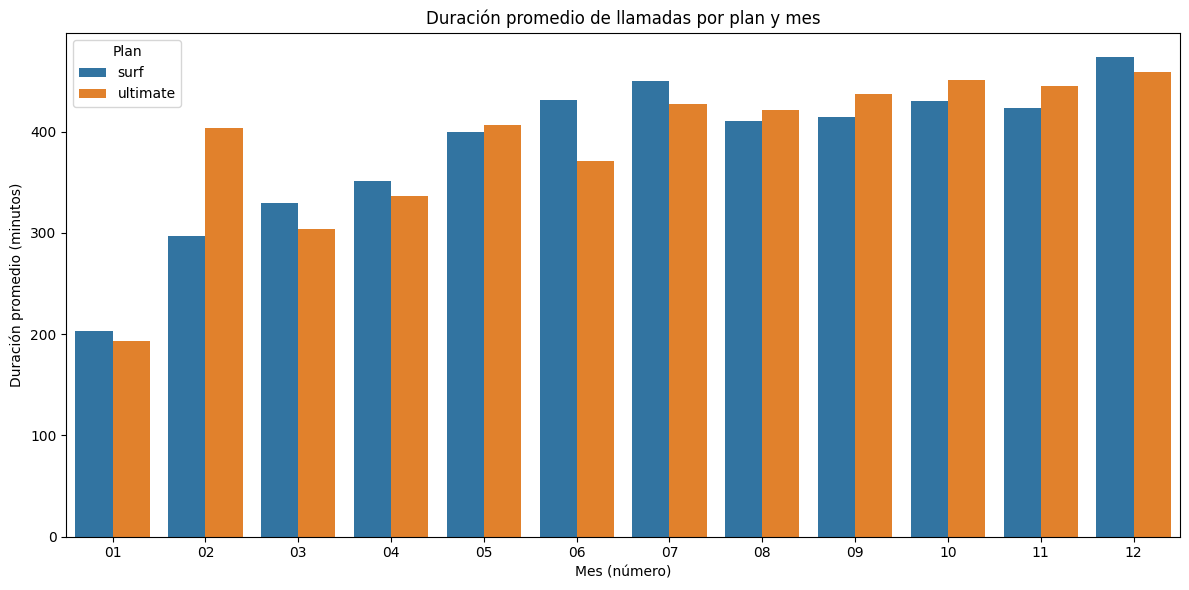

In [68]:
#Gráficar utilizando sns y plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_llamadas,
    x='month_num',
    y='rounded_duration',
    hue='plan'
)

# Personalizar
plt.title('Duración promedio de llamadas por plan y mes')
plt.xlabel('Mes (número)')
plt.ylabel('Duración promedio (minutos)')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()


In [69]:
#Parece estar parejo: en 6 meses hay más llamadas del plan ultimate, y en los otros 6, más llamadas del plan surf
#Pero al ser más caro 'Ultimate', probablemente sea más rentable
#Diciembre es el mes con mayor #de llamadas en ambos planes, asociado a las fiestas decembrinas

In [70]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# Filtrar por plan
surf_call = df_consolidado[df_consolidado['plan'] == 'surf']['rounded_duration']
ultimate_call = df_consolidado[df_consolidado['plan'] == 'ultimate']['rounded_duration']

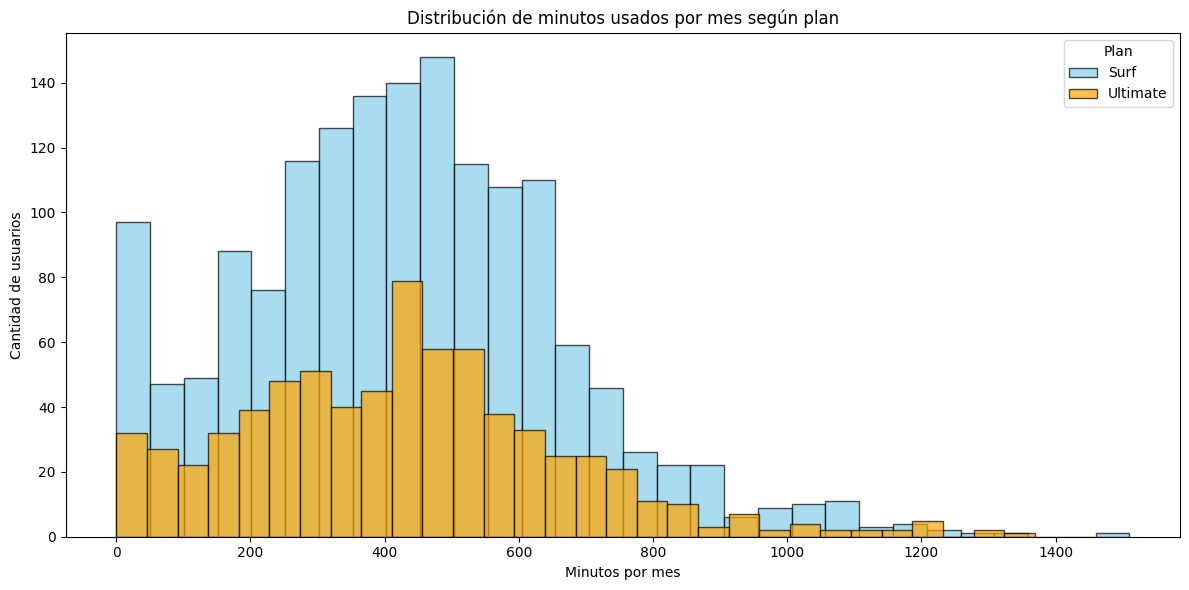

In [71]:
# Crear histograma
plt.figure(figsize=(12, 6))
plt.hist(surf_call, bins=30, alpha=0.7, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_call, bins=30, alpha=0.7, label='Ultimate', color='orange', edgecolor='black')

# Personalizar
plt.title('Distribución de minutos usados por mes según plan')
plt.xlabel('Minutos por mes')
plt.ylabel('Cantidad de usuarios')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

In [72]:
# Calcula la media y la varianza de la duración mensual de llamadas.
estadisticas_llamadas = df_consolidado.groupby('plan')['rounded_duration'].agg(['mean', 'var', 'std']).reset_index()
print(estadisticas_llamadas.round(2))

       plan    mean       var     std
0      surf  427.12  55455.58  235.49
1  ultimate  428.07  58543.88  241.96


In [73]:
#En promedio, los usuarios del plan Ultimate generan más ingresos solo por las llamadas.

<Figure size 800x600 with 0 Axes>

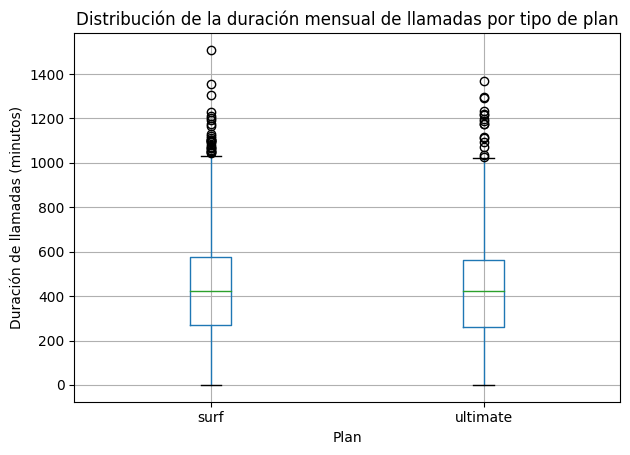

In [74]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.figure(figsize=(8, 6))
df_consolidado.boxplot(column='rounded_duration', by='plan')
plt.title('Distribución de la duración mensual de llamadas por tipo de plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Duración de llamadas (minutos)')
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusiones:

*Los usuarios de Surf muestran una mayor variabilidad en su consumo de minutos, incluyendo tanto bajos como altos niveles.

*Los usuarios de Ultimate tienden a usar minutos de forma más consistente, concentrándose en un rango medio de consumo, es decir, están menos dispersos.

*El plan Ultimate al incluir más minutos, parece ser que los usuarios están aprovechando más el plan de forma más predecible o, puede ser que, algunos clientes que saben que hablarán mucho, prefieran comprar este plan.

*El plan 'Ultimate' genera más ingresos en promedio por usuario (solo analizando las llamadas).

### Mensajes

In [75]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
df_mensajes = df_consolidado.groupby(['plan', 'month_num'])['messages_count'].mean().reset_index()
print(df_mensajes)

        plan month_num  messages_count
0       surf        01       10.500000
1       surf        02       12.000000
2       surf        03       15.260870
3       surf        04       17.400000
4       surf        05       24.012987
5       surf        06       25.298969
6       surf        07       27.033058
7       surf        08       28.777778
8       surf        09       30.762887
9       surf        10       33.839662
10      surf        11       32.385159
11      surf        12       38.600629
12  ultimate        01       15.500000
13  ultimate        02       21.571429
14  ultimate        03       20.250000
15  ultimate        04       22.047619
16  ultimate        05       32.103448
17  ultimate        06       29.340426
18  ultimate        07       32.830508
19  ultimate        08       38.478873
20  ultimate        09       37.895349
21  ultimate        10       39.443396
22  ultimate        11       38.606299
23  ultimate        12       45.006623


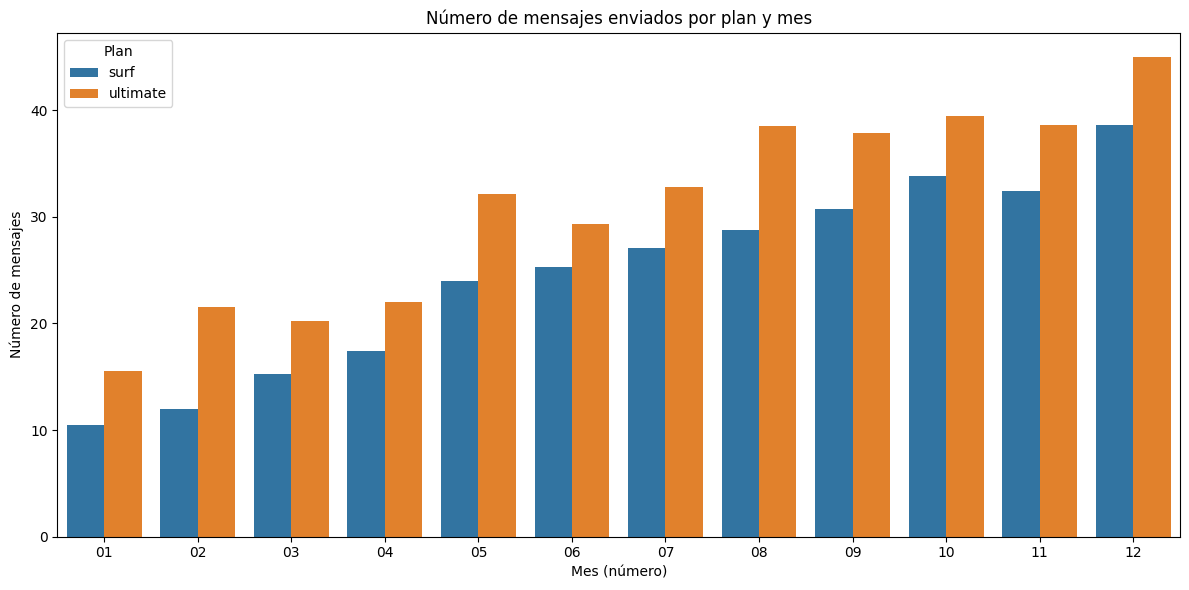

In [76]:
#Traza un gráfico de barras para visualizarlo
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_mensajes.reset_index(),
    x='month_num',
    y='messages_count',
    hue='plan'
)

#personalizar
plt.title('Número de mensajes enviados por plan y mes')
plt.xlabel('Mes (número)')
plt.ylabel('Número de mensajes')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

In [77]:
#Los usuarios de Ultimate tienden a enviar más mensajes por persona, en promedio.

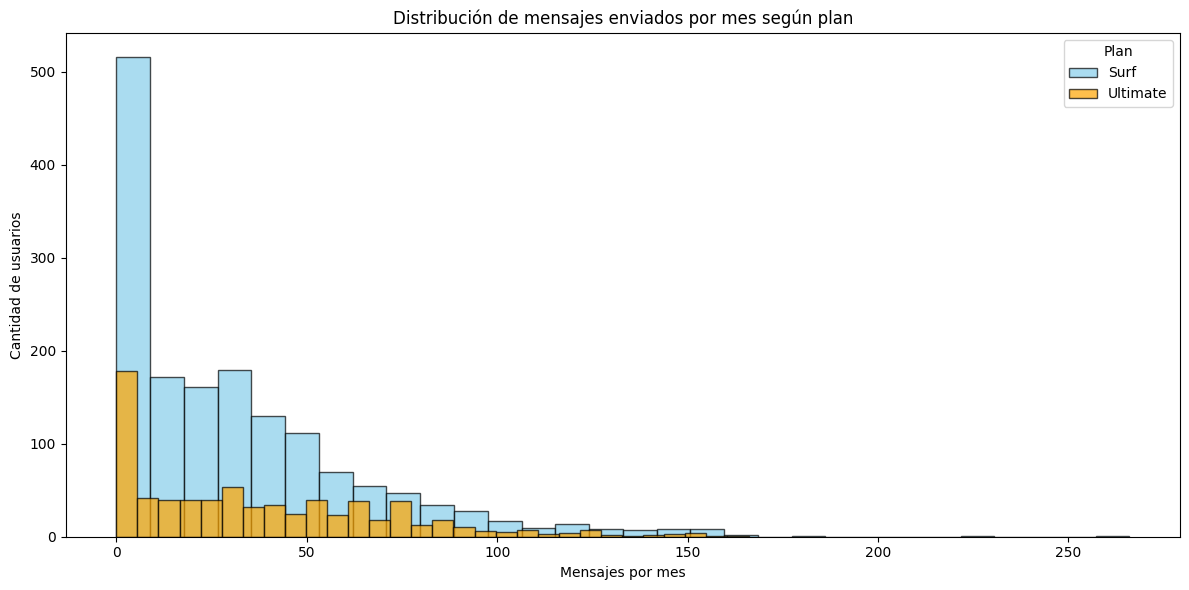

In [78]:
# Compara el número de mensajes que envian los usuarios de cada plan. Traza un histograma.
surf_msg = df_consolidado[df_consolidado['plan'] == 'surf']['messages_count']
ultimate_msg = df_consolidado[df_consolidado['plan'] == 'ultimate']['messages_count']

#crear histograma
plt.figure(figsize=(12, 6))
plt.hist(surf_msg, bins=30, alpha=0.7, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_msg, bins=30, alpha=0.7, label='Ultimate', color='orange', edgecolor='black')

#personalizar
plt.title('Distribución de mensajes enviados por mes según plan')
plt.xlabel('Mensajes por mes')
plt.ylabel('Cantidad de usuarios')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

In [79]:
#Hay una mayor dispersión en los clientes Surf

In [80]:
# Calcula la media, varianza y la desviacion estandar de la cantidad de mensajes por plan:
estadisticas_mensajes = df_consolidado.groupby('plan')['messages_count'].agg(['mean', 'var', 'std']).reset_index()
print(estadisticas_mensajes.round(2))

       plan   mean      var    std
0      surf  31.04  1126.12  33.56
1  ultimate  37.34  1209.83  34.78


<Figure size 800x600 with 0 Axes>

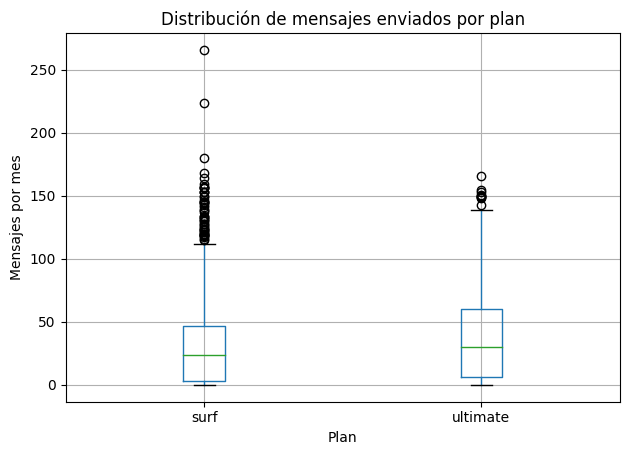

In [81]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes al mes

plt.figure(figsize=(8, 6))
df_consolidado.boxplot(column='messages_count', by='plan')
plt.title('Distribución de mensajes enviados por plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Mensajes por mes')
plt.grid(True)
plt.tight_layout()
plt.show()

#El plan 'Ultimate' tiene una menor dispersión de los datos.

#La mayoría de los clientes ni siquiera envía los mensajes permitidos dentro de su plan

#La mayoría de los usuarios envían entre cero y 80 mensajes al mes.

#Los usuarios de Ultimate tienden a enviar más mensajes por persona, en promedio.

### Internet

In [82]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
df_internet = df_consolidado.groupby(['plan', 'month_num'])['gb_used'].mean()
print(df_internet)

plan      month_num
surf      01            5.000000
          02           12.222222
          03           13.565217
          04           12.220000
          05           14.116883
          06           15.484536
          07           16.876033
          08           16.882716
          09           16.690722
          10           17.409283
          11           16.431095
          12           18.238994
ultimate  01            7.250000
          02           17.285714
          03           18.416667
          04           16.333333
          05           16.862069
          06           15.425532
          07           16.491525
          08           17.845070
          09           17.011628
          10           17.716981
          11           17.118110
          12           18.397351
Name: gb_used, dtype: float64


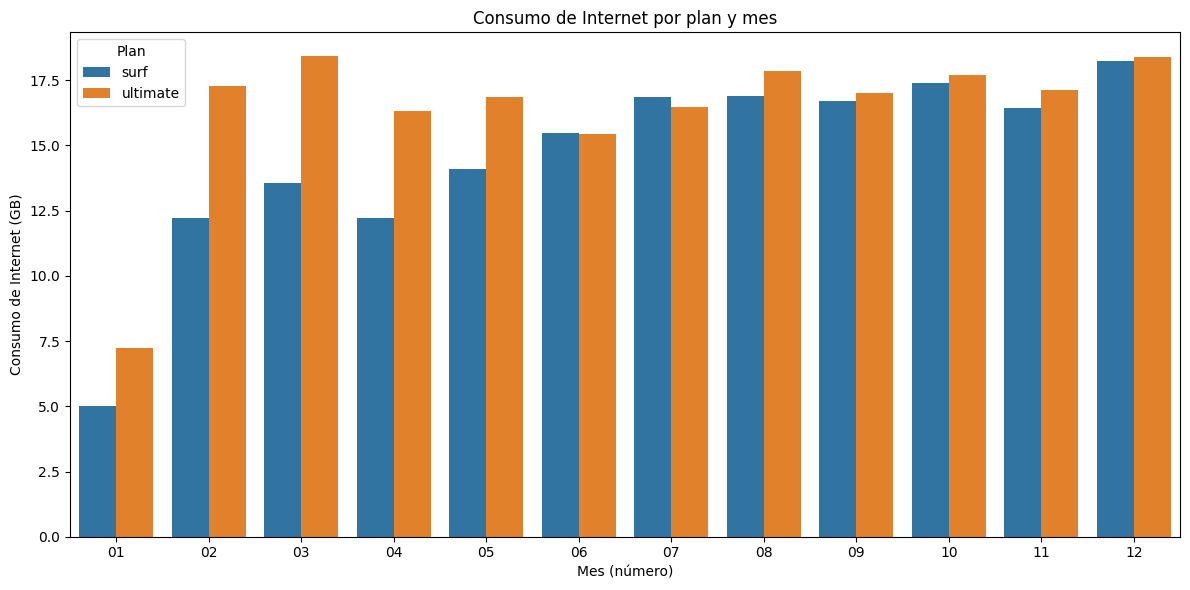

In [83]:
#Traza un gráfico de barras para visualizarlo
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_internet.reset_index(),
    x='month_num',
    y='gb_used',
    hue='plan'
)

#personalizarlo
plt.title('Consumo de Internet por plan y mes')
plt.xlabel('Mes (número)')
plt.ylabel('Consumo de Internet (GB)')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

#En los primeros meses del año, el consumo de internet en Ultimate es más alto; después son muy parecidos.

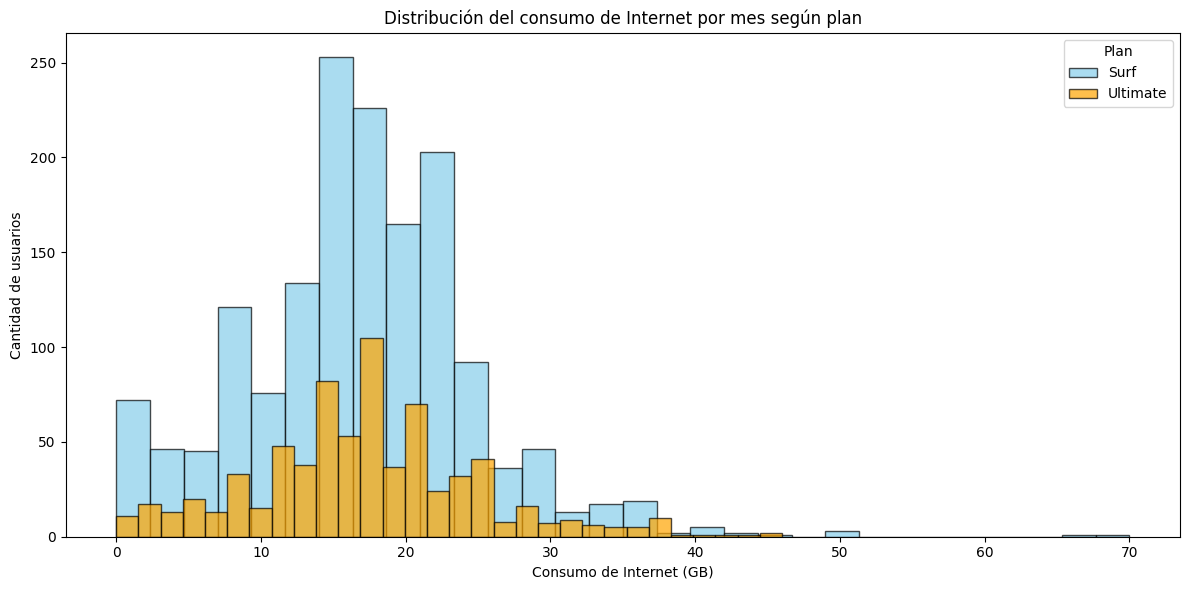

In [84]:
# Compara el consumo de internet por plan y por mes. Traza un histograma.
surf_int = df_consolidado[df_consolidado['plan'] == 'surf']['gb_used']
ultimate_int = df_consolidado[df_consolidado['plan'] == 'ultimate']['gb_used']

#crear histograma
plt.figure(figsize=(12, 6))
plt.hist(surf_int, bins=30, alpha=0.7, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_int, bins=30, alpha=0.7, label='Ultimate', color='orange', edgecolor='black')

#personalizar
plt.title('Distribución del consumo de Internet por mes según plan')
plt.xlabel('Consumo de Internet (GB)')
plt.ylabel('Cantidad de usuarios')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

In [85]:
# Calcula la media, varianza y la desviacion estandar:
estadisticas_internet = df_consolidado.groupby('plan')['gb_used'].agg(['mean', 'var', 'std']).reset_index()
print(estadisticas_internet.round(2))

       plan   mean    var   std
0      surf  16.61  62.40  7.90
1  ultimate  17.21  60.15  7.76


<Figure size 800x600 with 0 Axes>

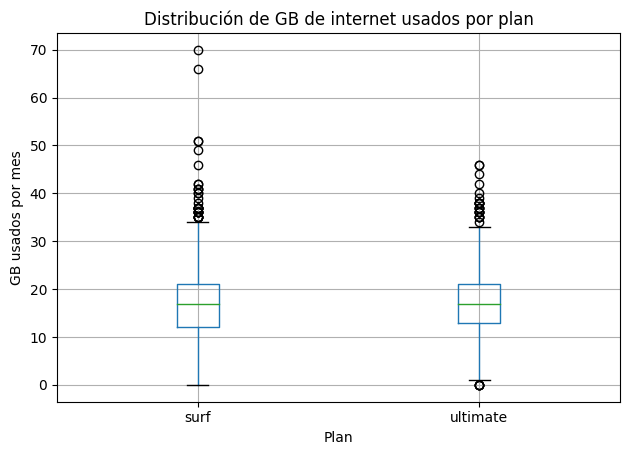

In [86]:
# Traza un diagrama de caja para visualizar la distribución de la cantidad de internet utilizada por mes:

plt.figure(figsize=(8, 6))
df_consolidado.boxplot(column='gb_used', by='plan')
plt.title('Distribución de GB de internet usados por plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('GB usados por mes')
plt.grid(True)
plt.tight_layout()
plt.show()

#Enero es un mes con muy poco consumo de internet en ambos planes.
#Diciembre es el mes con mayor consumo en Surf, pero para Ultimate es en marzo.
#Los usuarios de Surf muestran una mayor variabilidad en su consumo de GB
#El consumo de internet es más o menos entre 15 y 22 GB al mes.
#Ultimate presenta menor dispersión de los datos, es decir, están más agrupados. La mayoría de lo usuarios usan 17GB en promedio al mes. Y, a excepción de enero, el consumo se mantiene muy similar a lo largo del año.

## Ingreso

Describe estadísticamente los ingresos de los planes.

In [87]:
#Total_cost general
print(df_consolidado[df_consolidado['plan'] == 'surf']['total_cost'].mean().round(2))
print(df_consolidado[df_consolidado['plan'] == 'ultimate']['total_cost'].mean().round(2))

60.55
72.3


In [88]:
df_consolidado.groupby('plan')['total_cost'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1579.0,60.6,55.3,20.0,20.0,40.2,80.3,590.4
ultimate,724.0,72.3,11.4,70.0,70.0,70.0,70.0,182.0


El plan Ultimate genera más ingresos en promedio para la compañía (72 USD por usuario). Además de que son ingresos más estables y predecibles (ideal si se quieren hacer proyecciones financieras). La estabilidad también se puede asociar a que al ser un plan robusto, la mayoría de usuarios se apega a lo que contiene su plan. Por el contrario, el plan Surf es menos rentable y con ingresos volatiles, es decir, que algunos usuarios pagan el mínimo (20), mientras que otros se exceden por mucho (hasta 590). 

## Prueba las hipótesis estadísticas

#Prueba de hipótesis para la diferencia de medias:
#H0: El ingreso promedio de los usuarios de las tarifas Ultimate y Surf es igual.
#H1: El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.

In [89]:
alpha= 0.05
surf_cost = df_consolidado[df_consolidado['plan'] == 'surf']['total_cost']
ultimate_cost = df_consolidado[df_consolidado['plan'] == 'ultimate']['total_cost']

In [90]:
#Prueba Levene para igualdad de varianzas
levene_stat, levene_p = st.levene(surf_cost, ultimate_cost)
print('Prueba de Levene - valor p:', levene_p)

#Basado en eso decido el parámetro equal_var
if levene_p < alpha:
    print("Varianzas desiguales: usamos equal_var=False")
    equal_var = False
else:
    print("Varianzas iguales: usamos equal_var=True")
    equal_var = True

Prueba de Levene - valor p: 3.070976609395645e-83
Varianzas desiguales: usamos equal_var=False


In [91]:
#Considerando que salió equal_var= False, esa utilizamos:
results = st.ttest_ind(surf_cost, ultimate_cost, equal_var=False)

print('Valor p:', results.pvalue) #extraer el valor p

if results.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


Valor p: 1.218411585212325e-15
Rechazamos la hipótesis nula


In [92]:
#Rechazamos la hipótesis nula, es decir, que los ingresos promedio por plan son diferentes.
#Esto ya lo habíamos comprobado anteriormente. 

#Pruebas de hipótesis
#H0: El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es igual al de otras regiones.
#H1: El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

In [93]:
#extraer a las ciudades del DF users
main_users = users[users['city'].str.contains('New York-Newark-Jersey City', case=False)]
other_users = users[~users['user_id'].isin(main_users['user_id'])]

#incorporar con el costo
cities_income = df_consolidado[df_consolidado['user_id'].isin(main_users['user_id'])]['total_cost']
other_income = df_consolidado[df_consolidado['user_id'].isin(other_users['user_id'])]['total_cost']

In [94]:
# Prueba las hipótesis
alpha = 0.05

#Prueba Levene para igualdad de varianzas
levene_stat, levene_p = st.levene(surf_cost, ultimate_cost)
print('Prueba de Levene - valor p:', levene_p)

#Basado en eso decido el parámetro equal_var
if levene_p < alpha:
    print("Varianzas desiguales: usamos equal_var=False")
    equal_var = False
else:
    print("Varianzas iguales: usamos equal_var=True")
    equal_var = True

Prueba de Levene - valor p: 3.070976609395645e-83
Varianzas desiguales: usamos equal_var=False


In [95]:
#Considerando que salió equal_var= False, esa utilizamos:
results = st.ttest_ind(cities_income, other_income, equal_var=False)

# Imprime el resultado
print('Valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Valor p: 0.03870322661292944
Rechazamos la hipótesis nula


In [96]:
#Nuevamente rechazamos la hipótesis nula, es decir, los ingresos de los usuarios en el 
#área de NY-NJ es diferente al de los usuarios de otras regiones.

## Conclusión general

Tras el desarrollo de este análisis, pudimos constatar que el plan Ultimate genera más ingresos en promedio para la compañía (72USD vs 60USD del Surf), aun y cuando menos de la mitad de los clientes de la compañía lo tiene. Además de que son ingresos más estables y predecibles. Esto también puede estar asociado a que al ser un plan robusto, la mayoría de usuarios se apega a lo que contiene su plan. Ultimate parece ser más usado por clientes que son constantes y regulares, probablemente porque su trabajo o actividades así lo requiere. Por el contrario, el plan Surf es menos rentable y con ingresos volatiles, es decir, hay mucha diferencia entre los usuarios que pagan el minimo (20), y los que se exceden por mucho (hasta 590).  

Mi recomendación es que la compañía se enfoque en el lanzamiento de campañas para atraer más usuarios al plan Ultimate y fidelizarlos, para aprovechar la estabilidad que este plan conlleva.